In [1]:
import os
from time import time
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.datasets import make_circles, load_digits
from sklearn.preprocessing import StandardScaler, PowerTransformer
import umap
import umap.plot

from sle.modeling import generate_data
%load_ext autoreload
%autoreload 2

If you want to run the code but don't have access to the data, skip the cell below and run the following instead, to generate some synthetic data:

In [2]:
data_dir = os.path.join('..', 'data', 'processed')
data_all = feather.read_dataframe(os.path.join(data_dir, 'imid.feather'))
rest = feather.read_dataframe(os.path.join(data_dir, 'rest.feather'))

# TSNE

## Toy data

From https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

In [3]:
n_samples = 300
n_components = 2
perplexities = [5, 30, 50, 100]

In [4]:
X, y = make_circles(n_samples=n_samples, factor=.5, noise=.05)

red = y == 0
green = y == 1

circles, perplexity=5 in 0.88 sec
circles, perplexity=30 in 1.1 sec
circles, perplexity=50 in 0.95 sec
circles, perplexity=100 in 1.3 sec


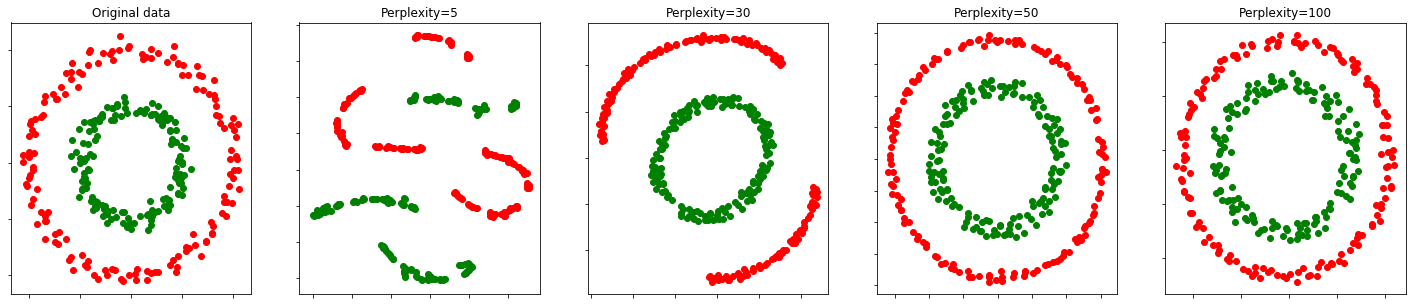

In [5]:
(fig, subplots) = plt.subplots(1, 5, figsize=(25, 5))
ax = subplots[0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_title("Original data")
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

## Real data

In [6]:
data_all.head()

Actinin      ASCA   Beta2GP1       C1q       C3b  Cardiolipin  CCP1arg  \
0   94.8911  1117.530  1328.0800   88.0225  115.4250      55.1872  42.1010   
1   99.9188  1295.260   119.1230  133.0480   59.4884      39.9630  39.0714   
2  121.3530  2636.220    38.4903   85.9066  117.8180      38.4903  42.0952   
3  145.0990   995.634   509.1220  171.8770  179.0070      60.6069  67.8459   
4   66.0117   994.225    40.8654  184.3840   85.9921      44.1397  42.5038   

   CCP1cit      CENP        CMV  ...       SMP  TIF1gamma       TPO      tTG  \
0  40.3490   65.5990  1177.9000  ...  157.0750   283.8950  1011.080  170.611   
1  39.0714   35.5006  1023.6600  ...  114.7650    84.1488  1111.850  146.075   
2  40.2934   53.7753    76.1163  ...  113.3960   154.8510   109.857  128.418   
3  52.4473  203.9280  8717.1000  ...  148.6730  4777.2800   765.190  211.928   
4  43.3220   33.4571  3849.9300  ...   66.8153   103.4140   716.172  237.993   

   Arthritis  Pleurisy  Pericarditis  Nefritis  dsDNA1  Class  
0        0.0       0.0           0.0       0.0    11.0    SLE  
1        0.0       0.0           0.0       1.0    63.0    SLE  
2        1.0       0.0           1.0       0.0     2.6    SLE  
3        1.0       0.0           0.0       1.0     1.6    SLE  
4        1.0       0.0           0.0       1.0    22.0    SLE  

[5 rows x 63 columns]

In [7]:
data_all.shape

(1408, 63)

In [8]:
data_all['Class'].value_counts()

SLE        483
BBD        361
IMID       346
nonIMID    218
Name: Class, dtype: int64

In [9]:
symptoms = ['Arthritis', 'Pleurisy', 'Pericarditis', 'Nefritis']
for col in symptoms: # convert to boolean, so 0 or NaN become false
    data_all[col] = data_all[col].fillna(False).astype('bool')

In [10]:
data_all['Symptoms'] = 'more_than_one' # new column for symptoms with default value for patients with more than one symptom
data_all.loc[data_all['Arthritis'] & ~data_all[['Pleurisy','Pericarditis','Nefritis']].any(1),'Symptoms'] = 'arthritis_only' # patients with only arthritis
data_all.loc[data_all['Nefritis'] & ~data_all[['Pleurisy','Pericarditis','Arthritis']].any(1),'Symptoms'] = 'nefritis_only' # patients with only nefritis
data_all.loc[data_all[['Pleurisy','Pericarditis']].any(1) & ~data_all[['Nefritis','Arthritis']].any(1),'Symptoms'] = 'pleurisy_or_pericarditis_only' # patients with either pleuritis or pericardits and nothing else
data_all.loc[~data_all[symptoms].any(1),'Symptoms'] = 'none' # patients with no symptoms

In [11]:
data_all.Symptoms.value_counts()

none                             1040
nefritis_only                     108
more_than_one                     102
arthritis_only                    101
pleurisy_or_pericarditis_only      57
Name: Symptoms, dtype: int64

In [12]:
df = data_all.copy()
y_class = data_all["Class"]
y_symptom = data_all['Symptoms']
X = np.array(data_all.loc[:, ~data_all.columns.isin(symptoms + ['Class'] + ['Symptoms'] + ['dsDNA1'])])

### Default parameters

In [13]:
tsne = TSNE(random_state=0, verbose=1)
Y_tsne = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1408 samples in 0.014s...
[t-SNE] Computed neighbors for 1408 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1408
[t-SNE] Computed conditional probabilities for sample 1408 / 1408
[t-SNE] Mean sigma: 1413.796264
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.268234
[t-SNE] KL divergence after 1000 iterations: 1.017738


In [14]:
# add tsne results back to pandas dataframe
df['tsne_1'] = Y_tsne[:,0]
df['tsne_2'] = Y_tsne[:,1]

(-52.50039465973089, 40.55504019806097, -62.39752480691256, 49.14921090310397)

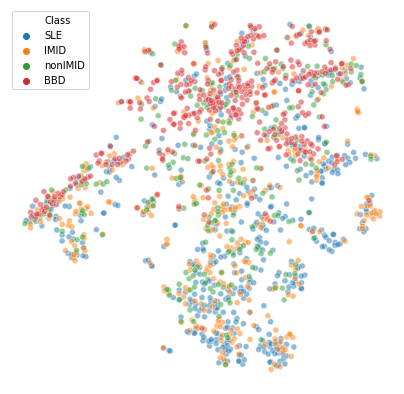

In [15]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="Class",
    data=df,
    alpha=0.5)
plt.axis('off')

- The blood bank controls (`BBD`) are the most prominent cluster
- SLE patients also seem to cluster together at the bottom
- IMIDs seem a bit closer to SLE than the nonIMIDs are
- There could be a 2nd cluster smaller that is a mix of all 4 groups. Check if we also see this with different perplexities/UMAP 

### Different perplexities

In [16]:
perplexities = np.linspace(5,50,10)

perplexity=5 in 3.2 sec
perplexity=10 in 3.4 sec
perplexity=15 in 3.8 sec
perplexity=20 in 3.9 sec
perplexity=25 in 4.2 sec
perplexity=30 in 4.5 sec
perplexity=35 in 4.6 sec
perplexity=40 in 4.8 sec
perplexity=45 in 4.7 sec
perplexity=50 in 5.1 sec


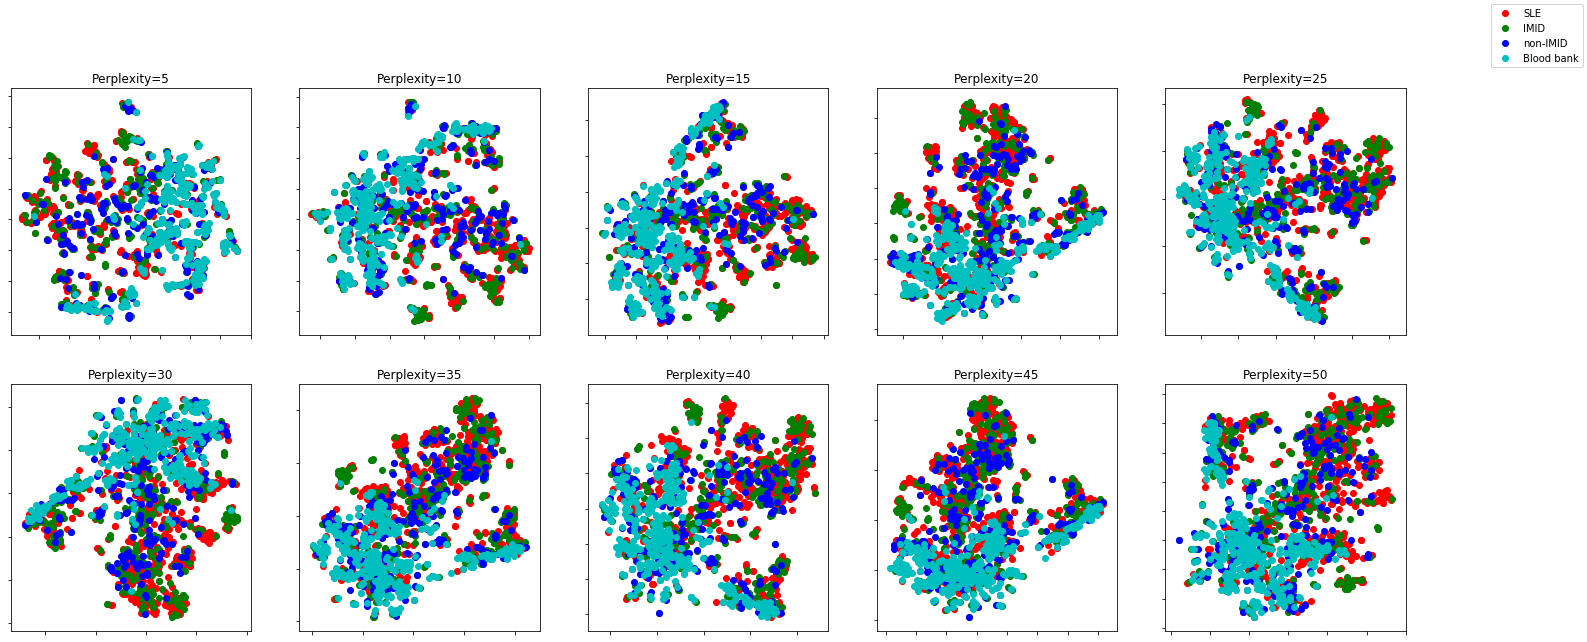

In [17]:
SLE = y_class.values == "SLE"
IMID = y_class.values == "IMID"
nonIMID = y_class.values == "nonIMID"
BBD = y_class.values == "BBD"

(fig, subplots) = plt.subplots(2, round(len(perplexities)/2), figsize=(25, 10))
i = 0
j = 0
for perplexity in perplexities:
    if i == round(len(perplexities)/2):
        i = 0
        j = 1
    ax = subplots[j][i]

    t0 = time()
    tsne = TSNE(random_state=0, perplexity=perplexity)
    Y_tsne = tsne.fit_transform(X)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y_tsne[SLE, 0], Y_tsne[SLE, 1], c="r")
    ax.scatter(Y_tsne[IMID, 0], Y_tsne[IMID, 1], c="g")
    ax.scatter(Y_tsne[nonIMID, 0], Y_tsne[nonIMID, 1], c="b")
    ax.scatter(Y_tsne[BBD, 0], Y_tsne[BBD, 1], c="c")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    i += 1

fig.legend(['SLE', 'IMID', 'non-IMID', 'Blood bank'])

Different perplexities don't seem to change the overall picture too much 

# UMAP

## Toy data

### Default parameters

In [18]:
digits = load_digits()

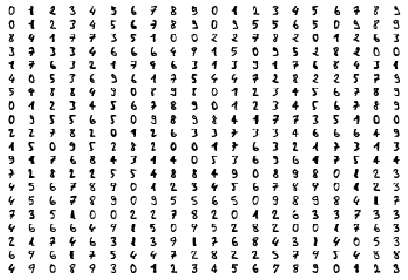

In [19]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [20]:
reducer = umap.UMAP(random_state=42)

In [21]:
embedding = reducer.fit_transform(digits.data)
embedding.shape

(1797, 2)

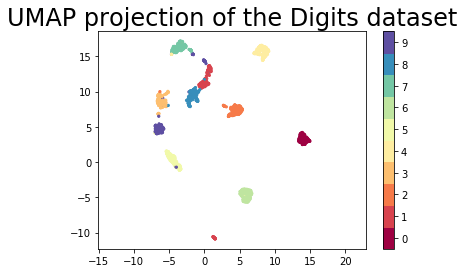

In [22]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

### Play with parameters

In [23]:
np.random.seed(42)
data = np.random.rand(800, 4) # sample from 4 dimensions

In [24]:
fit = umap.UMAP()
%time u = fit.fit_transform(data)

CPU times: user 6.46 s, sys: 522 ms, total: 6.98 s
Wall time: 2.91 s


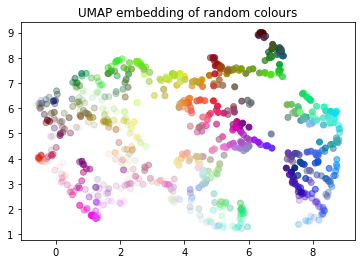

In [25]:
plt.scatter(u[:,0], u[:,1], c=data) # plot 4D data as: R,G,B,alpha
plt.title('UMAP embedding of random colours');

In [26]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
    plt.title(title, fontsize=18)

#### `n_neighbors`

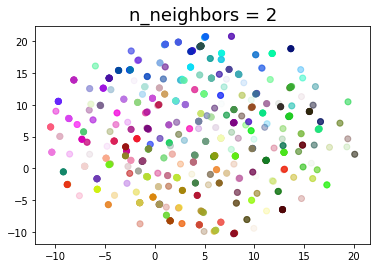

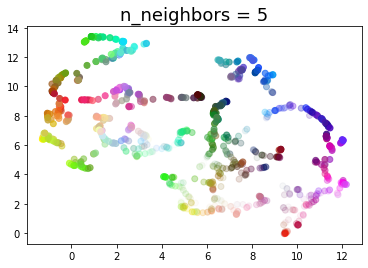

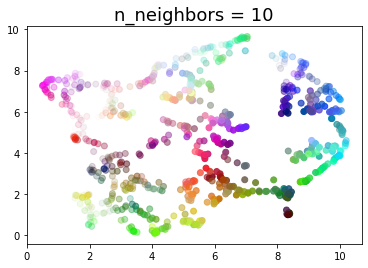

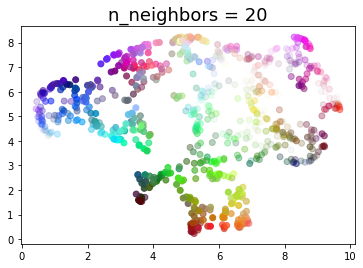

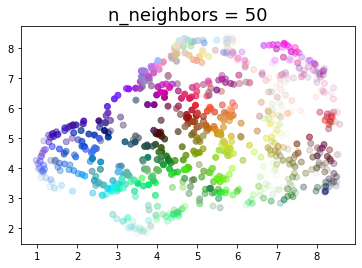

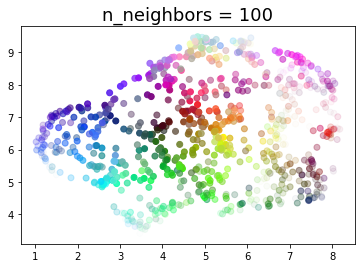

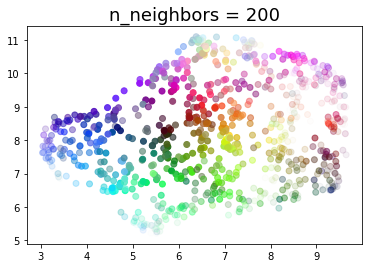

In [27]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

#### `min_dist`

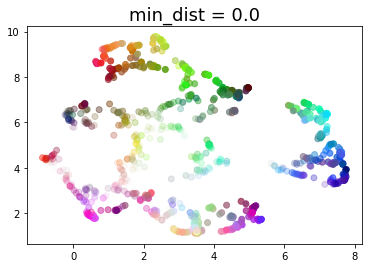

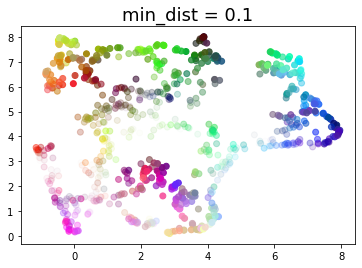

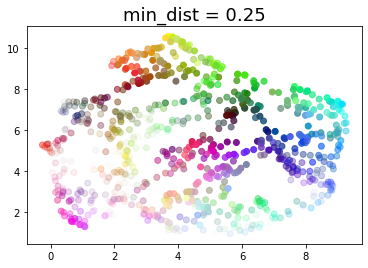

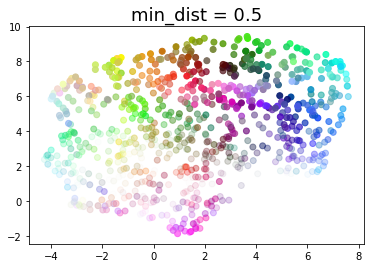

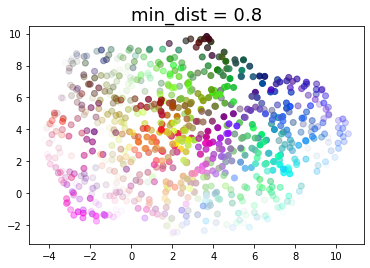

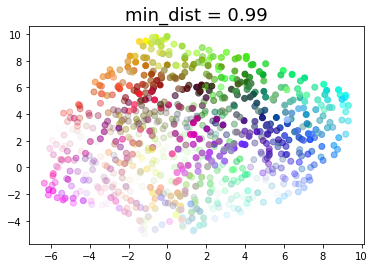

In [28]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

### Real data

In [29]:
sc = StandardScaler()
trf = PowerTransformer(method='box-cox')

In [30]:
df_combined = pd.concat([data_all, rest[rest.Class.isin(['preSLE', 'rest_large'])]])
df_combined['Class'] = pd.Categorical(df_combined.Class, categories = ['SLE','IMID','nonIMID','rest_large','BBD','preSLE']) # order for plotting: largest groups first
df_combined.sort_values(by='Class', inplace=True)
X_combined = np.array(df_combined.loc[:, ~df_combined.columns.isin(symptoms + ['Class'] + ['Symptoms'] + ['dsDNA1'])])
X_combined_scaled = trf.fit_transform(X_combined+1)

#### Default parameters

In [31]:
umap_obj = umap.UMAP(random_state=42)
Y_umap = umap_obj.fit_transform(X)

In [32]:
Y_umap_combined = umap_obj.fit_transform(X_combined_scaled)

In [33]:
# add umap results back to pandas dataframes
df['umap_1'] = Y_umap[:,0]
df['umap_2'] = Y_umap[:,1]

In [34]:
# add umap results back to pandas dataframes
df_combined['umap_1'] = Y_umap_combined[:,0]
df_combined['umap_2'] = Y_umap_combined[:,1]

In [35]:
df_combined.Class.value_counts()

SLE           483
rest_large    462
BBD           361
IMID          346
nonIMID       218
preSLE         17
Name: Class, dtype: int64

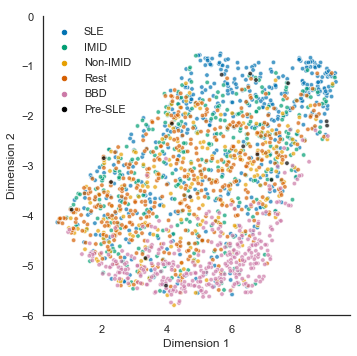

In [36]:
with sns.plotting_context("paper"):
    sns.set(font="Arial")
    sns.set_style('white')
    f, ax = plt.subplots(figsize=(5.5, 5.5))
    g = sns.scatterplot(x='umap_1',y='umap_2',
                    hue='Class', style='Class', size='Class',
                    markers = {"SLE": "o", "rest_large": "o", "BBD": "o", "IMID": "o", "nonIMID": "o", "preSLE": "o"},
                    sizes = {"SLE": 20, "rest_large": 20, "BBD": 20, "IMID": 20, "nonIMID": 20, "preSLE": 20},
                    palette={"SLE": '#0072B2', "rest_large": '#D55E00', "BBD": '#CC79A7', "IMID": '#009E73', "nonIMID": '#E69F00', "preSLE": '#000000'},
                    alpha=.7,
                    data=df_combined,
                    ax=ax)
    legend = ax.legend(frameon=False, loc = 'upper left', bbox_to_anchor=(0,1.05)) # remove legend box; push legend up from upper left
    ax.set_xlabel('Dimension 1'); ax.set_ylabel('Dimension 2'); 
    ax.set_ylim(-6,0)
    new_labels = ['','SLE','IMID','Non-IMID','Rest','BBD','Pre-SLE']; # remove legend title and change group spelling
    for t, l in zip(legend.texts, new_labels): t.set_text(l)
    sns.despine(fig=f,ax=ax)
    #f.savefig('umap.png', bbox_inches='tight', dpi=300, transparent=True)
    #sf.savefig('umap.pdf', bbox_inches='tight', transparent=True)

In [37]:
def umap_vs_tsne(df,label):
    plt.figure(figsize=(14,7))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(
        x="tsne_1", y="tsne_2",
        hue=label,
        data=df,
        alpha=0.5,
        legend=False,
        ax=ax1)
    ax1.set_title("t-SNE (default)")
    plt.axis('off')
    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(
        x="umap_1", y="umap_2",
        hue=label,
        data=df,
        alpha=0.5,
        ax=ax2)
    ax2.set_title("UMAP (default)")
    plt.axis('off')

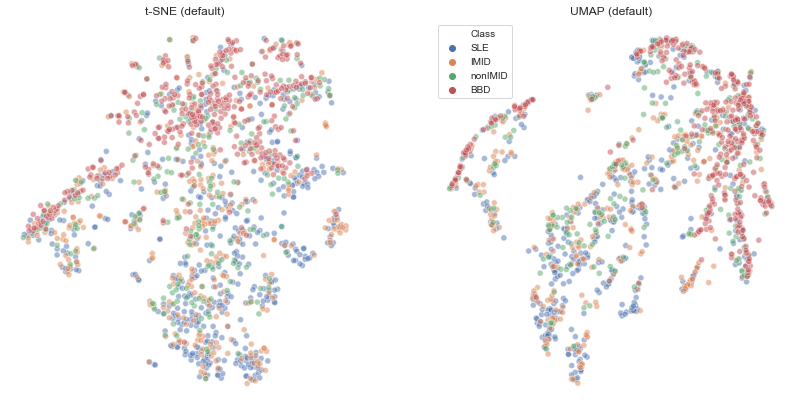

In [38]:
umap_vs_tsne(df,'Class')

Looks fairly similar to t-SNE results. Clustering of blood bank controls is even clearer, while perhaps SLE is less clear

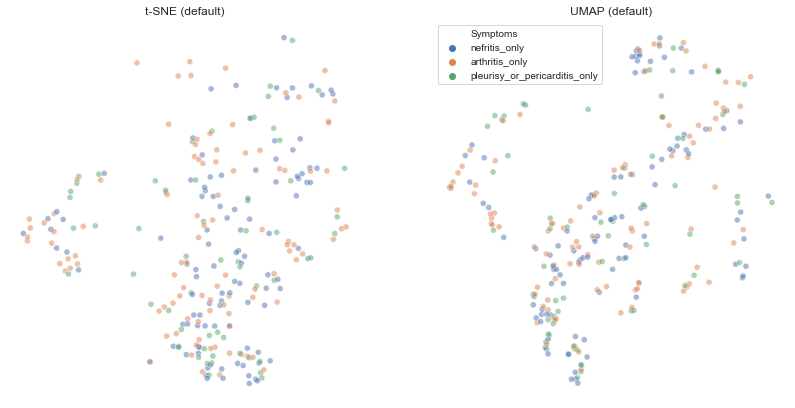

In [39]:
# filter patients with no symptoms
umap_vs_tsne(df[df['Symptoms'].isin(['nefritis_only','arthritis_only','pleurisy_or_pericarditis_only', 'nefritis'])],'Symptoms')

Interactive UMAP with all points:

In [40]:
from bokeh.plotting import show, save, output_notebook, output_file
output_notebook()

Loading BokehJS ...

In [41]:
hover_data = df[['Class','Symptoms']].reset_index()

In [42]:
mapper = umap_obj.fit(X)

In [43]:
p = umap.plot.interactive(mapper, labels=y_class, hover_data=hover_data, point_size=4, theme='fire')
show(p)

In [44]:
p = umap.plot.interactive(mapper, labels=y_symptom, hover_data=hover_data, point_size=4, theme='fire')
show(p)

#### Different parameters

In [45]:
n_neighborss = (2, 5, 10, 20, 50, 100, 200)
min_dists = (0.0, 0.1, 0.25, 0.5, 0.8, 0.99)

/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn

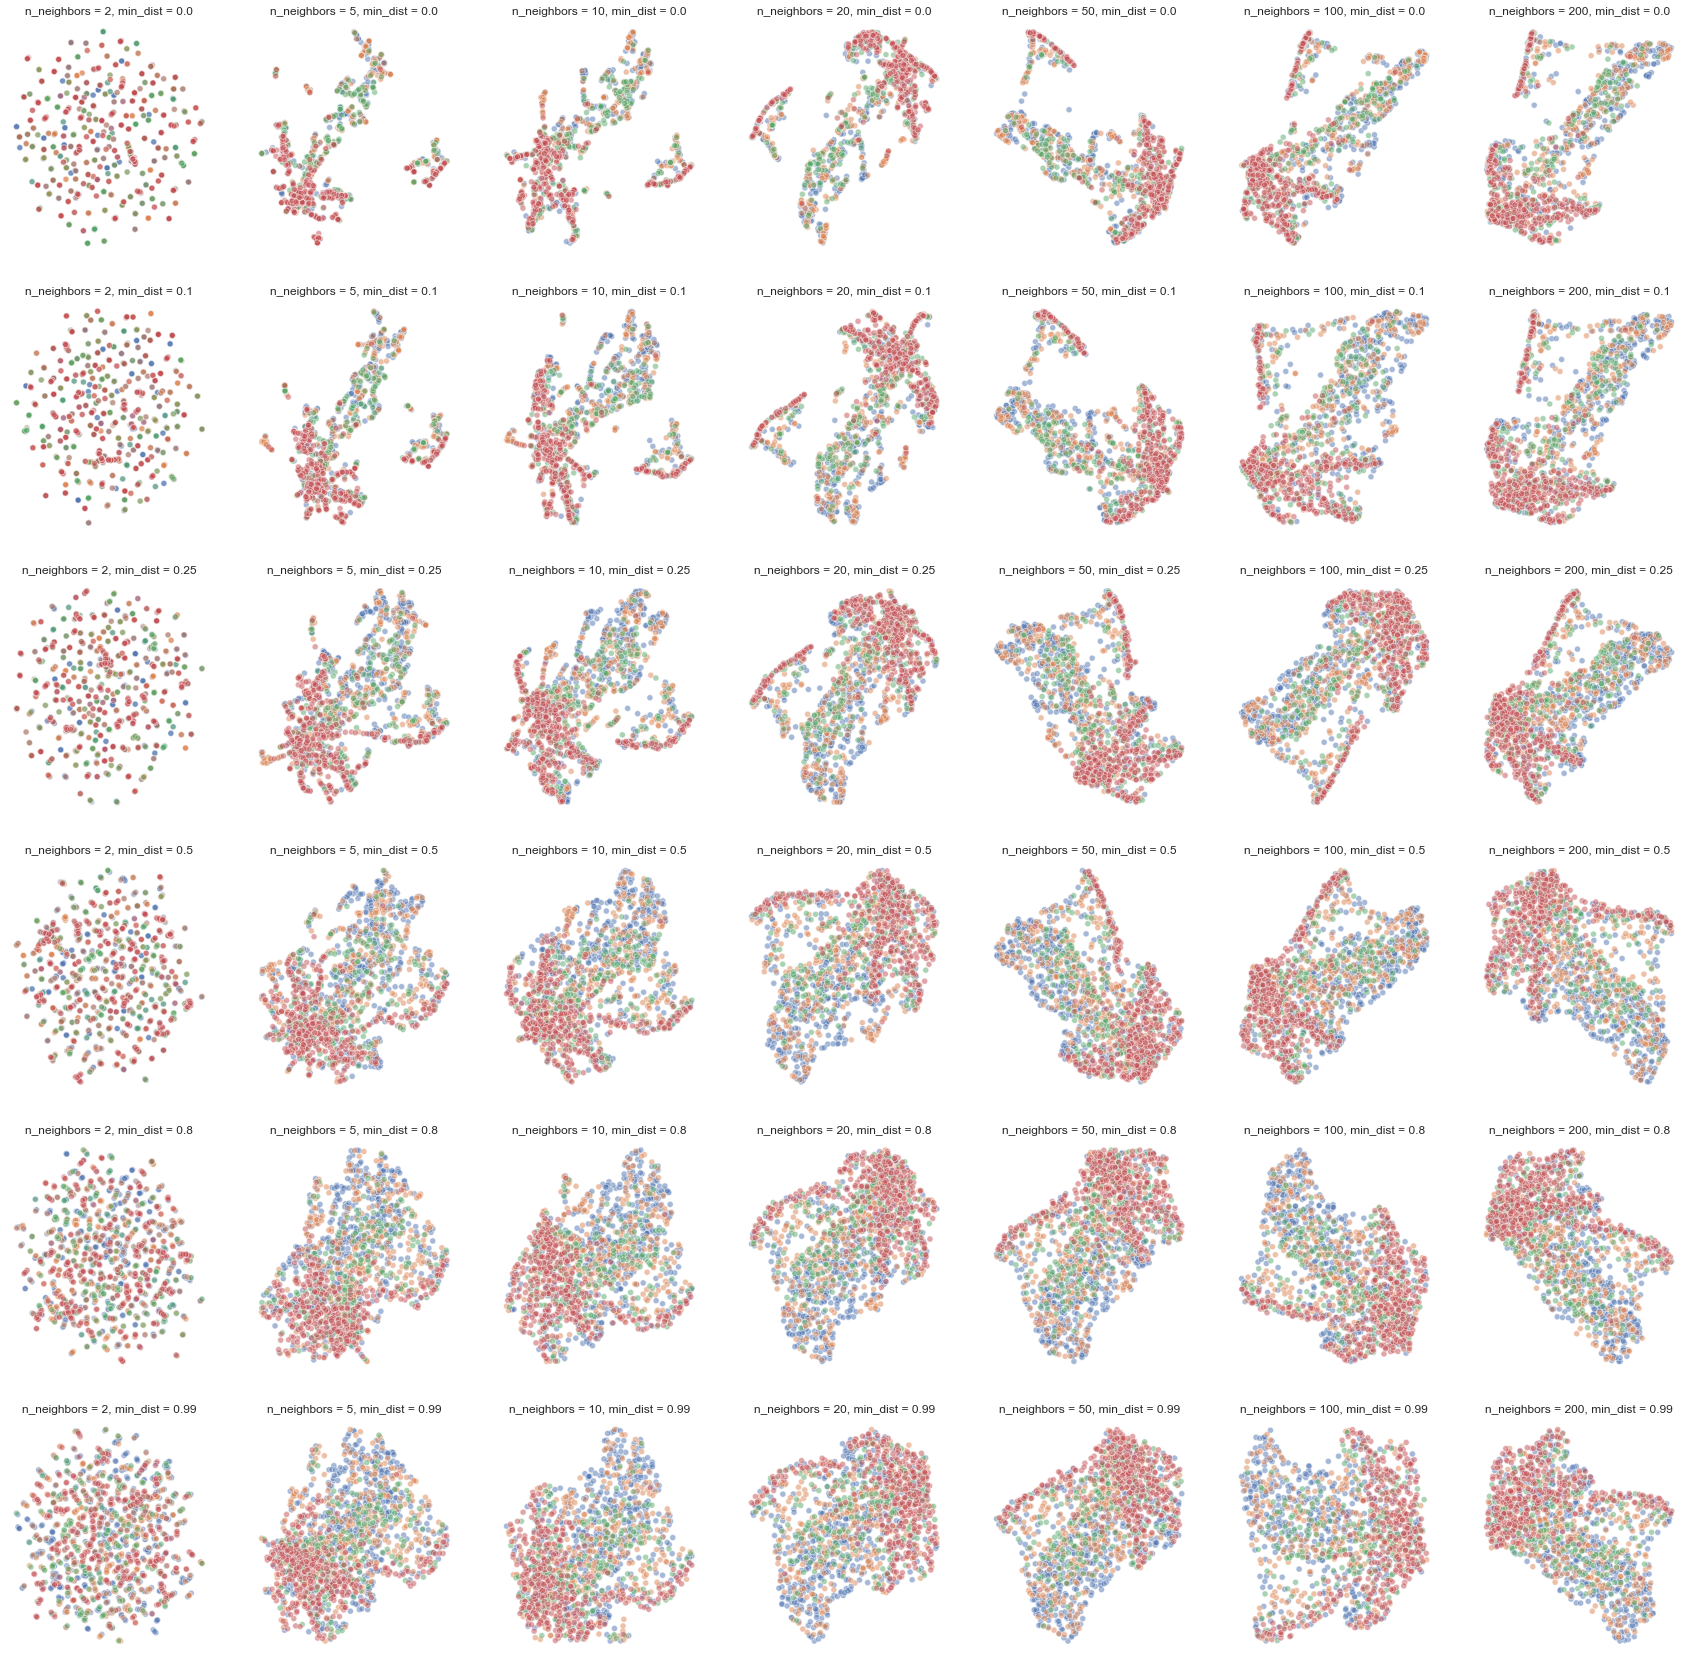

In [46]:
(fig, subplots) = plt.subplots(len(min_dists), len(n_neighborss), figsize=(30,30))

for i, n_neighbors in enumerate(n_neighborss):
    for j, min_dist in enumerate(min_dists):
        ax = subplots[j][i]
        u = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit_transform(X);
        df_params = pd.DataFrame({'umap_1': u[:,0], 'umap_2': u[:,1], 'Class': y_class.values})
        sns.scatterplot(x='umap_1', y='umap_2', hue='Class', data=df_params, alpha=0.5, ax=ax, legend=False)
        ax.set_title('n_neighbors = {}, min_dist = {}'.format(n_neighbors, min_dist))
        ax.axis('off')

Overall pattern remains the same. Could consider slightly higher than default parameters (for both) if we want a less "pinched" shape